# An intro to Self-Organizing Class Embeddings

**Author:** Raphael Pisoni<br>
**Date created:** 2023/10/12<br>
**Last modified:** 2023/10/17<br>
**Description:** Image classification with self-organizing class embeddings. Competitive results with other losses.

## Find more information about SOC-Embeddings in the original blog-post: [https://www.rpisoni.dev/posts/self-organizing-class-embeddings/](https://www.rpisoni.dev/posts/self-organizing-class-embeddings/)

## Setup

In [1]:
# !pip install -q tensorflow~=2.12.0
# !pip install -q -U keras_cv==0.5.0

In [2]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3
env: TPU_NAME=local


In [3]:
import os
import logging

import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

try:
    # try to run with colab TPU or TPU-VM
    device_name = os.environ.get("COLAB_TPU_ADDR")
    if device_name is not None:
        TPU_ADDRESS = "grpc://" + device_name
    else:
        TPU_ADDRESS = "local"
    os.environ["TPU_NAME"] = TPU_ADDRESS
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    strategy = tf.distribute.TPUStrategy(cluster_resolver)
    print("Number of TPU devices:", strategy.num_replicas_in_sync)
except Exception:
    print("TPU not found.")
    gpus = tf.config.list_physical_devices("GPU")
    if gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_visible_devices(gpus[0], "GPU")
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
        print("Using GPU devices:", strategy.num_replicas_in_sync)
    else:
        print("No GPU found. Running on CPU.")
        strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")

TPU not found.
Using GPU devices: 1


## Hyperparameters

In [4]:
DATASET = "cifar10"  # "cats_and_dogs" "cifar10" or "cifar100"
EMBEDDING_DIMENSIONS = [10, 5, 1]

EPOCHS = 30
BATCH_SIZE = 128


histories = {}

## Load the dataset

In [5]:
if DATASET in ["cats_and_dogs", "cifar10"]:
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
elif DATASET == "cifar100":
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
else:
    raise NotImplementedError

x_train = x_train.astype("uint8")
x_test = x_test.astype("uint8")

N_CLASSES = np.max(y_train) + 1

y_train = tf.squeeze(y_train, axis=1)
y_test = tf.squeeze(y_test, axis=1)

if DATASET == "cats_and_dogs":
    N_CLASSES = 2
    class_names = ["cats", "dogs"]
elif DATASET == "cifar10":
    class_names = [
        "airplanes",
        "cars",
        "birds",
        "cats",
        "deer",
        "dogs",
        "frogs",
        "horses",
        "ships",
        "trucks",
    ]
else:
    class_names = None

## Define training and validation sets

In [6]:
INPUT_SHAPE = x_train.shape[1:]
N_SAMPLES = x_train.shape[0]
if DATASET == "cats_and_dogs":
    N_SAMPLES = N_SAMPLES // 5
STEPS_PER_EPOCH = N_SAMPLES // BATCH_SIZE
print(x_train.shape, y_train.shape)

(50000, 32, 32, 3) (50000,)


In [7]:
print("DATASET:", DATASET)
print("INPUT_SHAPE:", INPUT_SHAPE)
print("EMBEDDING_DIMENSIONS:", EMBEDDING_DIMENSIONS)
print("N_CLASSES:", N_CLASSES)

DATASET: cifar10
INPUT_SHAPE: (32, 32, 3)
EMBEDDING_DIMENSIONS: [10, 5, 1]
N_CLASSES: 10


In [8]:
augmenter = tf.keras.Sequential(
    [
        keras_cv.layers.RandomFlip(mode="horizontal"),
        keras_cv.layers.RandomChoice(
            layers=[
                keras_cv.layers.preprocessing.RandomlyZoomedCrop(
                    height=INPUT_SHAPE[0],
                    width=INPUT_SHAPE[1],
                    zoom_factor=(0.8, 1.2),
                    aspect_ratio_factor=(3.0 / 4.0, 4.0 / 3.0),
                    interpolation="nearest",
                ),
                keras_cv.layers.preprocessing.RandomlyZoomedCrop(
                    height=INPUT_SHAPE[0],
                    width=INPUT_SHAPE[1],
                    zoom_factor=(0.8, 1.2),
                    aspect_ratio_factor=(3.0 / 4.0, 4.0 / 3.0),
                    interpolation="bilinear",
                ),
            ]
        ),
        keras_cv.layers.preprocessing.RandomColorJitter(
            value_range=(0, 255),
            brightness_factor=(-0.2, 0.2),
            contrast_factor=(-0.2, 0.2),
            saturation_factor=(0.4, 0.6),
            hue_factor=0.2,
        ),
    ]
)


def augment_data(images, labels):
    outputs = augmenter({"images": images, "labels": labels})
    return tf.cast(outputs["images"], tf.float32), tf.cast(labels, tf.int32)


def dont_augmenta_data(images, labels):
    return tf.cast(images, tf.float32), tf.cast(labels, tf.int32)


train_x = tf.data.Dataset.from_tensor_slices(x_train)
val_x = tf.data.Dataset.from_tensor_slices(x_test)

train_y = tf.data.Dataset.from_tensor_slices(y_train)
val_y = tf.data.Dataset.from_tensor_slices(y_test)

train_ds = tf.data.Dataset.zip((train_x, train_y))
val_ds = tf.data.Dataset.zip((val_x, val_y))

if DATASET == "cats_and_dogs":
    train_ds = train_ds.filter(lambda x, y: y == 3 or y == 5)
    train_ds = train_ds.map(
        lambda x, y: (x, int(y == 5)), num_parallel_calls=tf.data.AUTOTUNE
    )
    val_ds = val_ds.filter(lambda x, y: y == 3 or y == 5)
    val_ds = val_ds.map(
        lambda x, y: (x, int(y == 5)), num_parallel_calls=tf.data.AUTOTUNE
    )


train_ds = (
    train_ds.cache()
    .repeat()
    .shuffle(buffer_size=1000, seed=0, reshuffle_each_iteration=True)
    .map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    val_ds.map(dont_augmenta_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .cache()
)

# Show training images

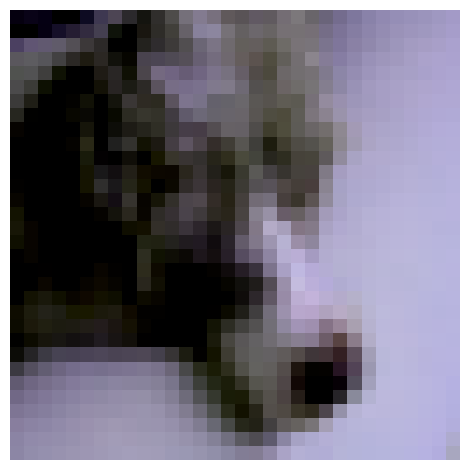

dogs



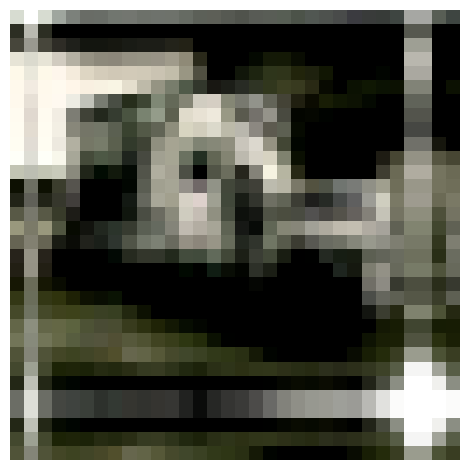

trucks



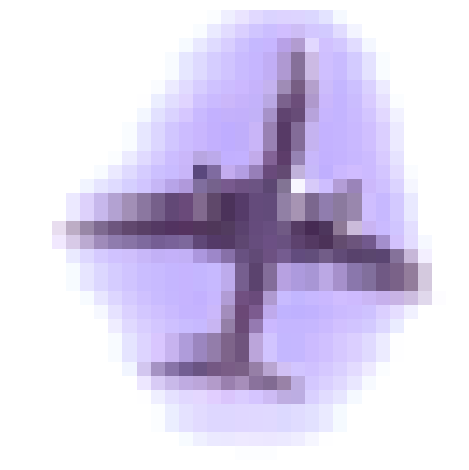

airplanes



In [9]:
sx, sy = next(iter(train_ds.take(1)))

for i in range(sx.shape[0]):
    if i == 3:
        break
    plt.imshow(sx[i].numpy().astype(np.uint8), aspect="equal")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    if class_names is not None:
        print(class_names[sy[i]])
    print()

# Show validation images

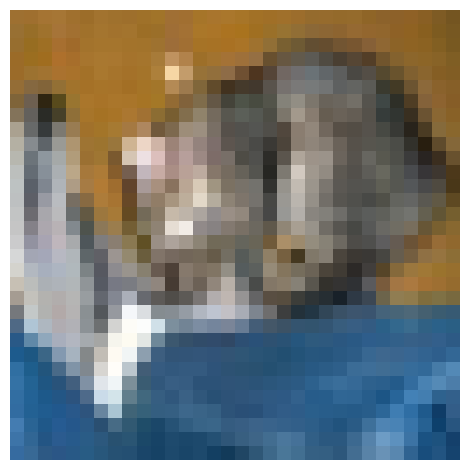

cats
0.0 255.0


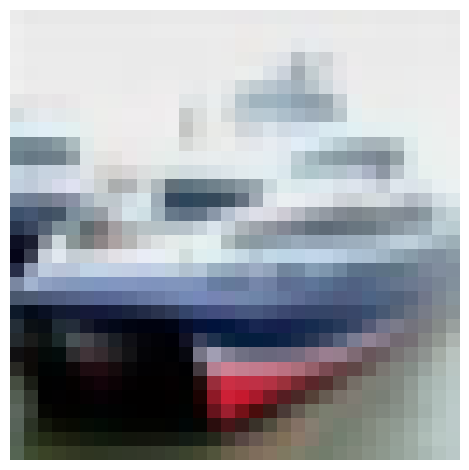

ships
0.0 255.0


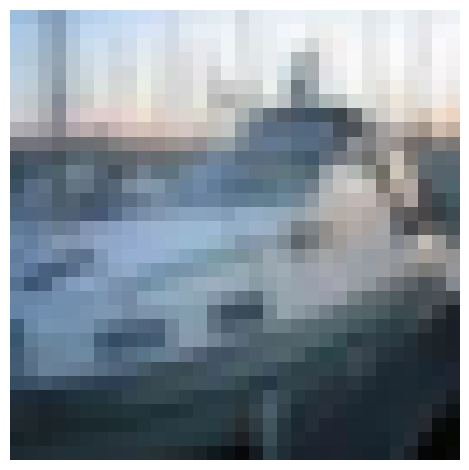

ships
0.0 255.0


In [10]:
sx, sy = next(iter(val_ds.take(1)))

for i in range(sx.shape[0]):
    if i == 3:
        break
    plt.imshow(sx[i].numpy().astype(np.uint8), aspect="equal")
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    if class_names is not None:
        print(class_names[sy[i]])
    print(sx.numpy().min(), sx.numpy().max())

# Define the model

In [11]:
class SOCModel(tf.keras.Model):
    def __init__(
        self,
        image_encoder,
        class_encoder,
        n_classes,
        embedding_dims,
        learn_scale=False,
        label_smoothing=0.1,
        *args,
        **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.image_encoder = image_encoder
        self.class_encoder = class_encoder
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.accuracy_tracker = tf.keras.metrics.Mean(name="acc")
        self.dummy_classes = tf.range(n_classes, dtype=tf.int32)
        self.n_classes = n_classes
        self.embedding_dims = embedding_dims
        self.learn_scale = learn_scale
        self.label_smoothing = label_smoothing
        self.unnormalized_log_probs = False

    @property
    def metrics(self):
        return [self.loss_tracker, self.accuracy_tracker]

    @staticmethod
    def _log_prob(mu, scale_diag, x, unnormalized):
        log_unnormalized = -0.5 * tf.math.squared_difference(
            x / scale_diag, mu / scale_diag
        )
        if unnormalized:
            return tf.reduce_sum(log_unnormalized)
        log_normalization = tf.constant(
            0.5 * np.log(2.0 * np.pi), dtype=mu.dtype
        ) + tf.math.log(scale_diag)
        return tf.reduce_sum(log_unnormalized - log_normalization)

    def log_prob(self, mu, scale_diag, x, unnormalized=False):
        batch_log_prob = tf.vectorized_map(
            lambda _x: tf.vectorized_map(
                lambda _params: self._log_prob(
                    _params[0], _params[1], _x, unnormalized=unnormalized
                ),
                (mu, scale_diag),
            ),
            x,
        )
        return batch_log_prob

    def loss_fn(self, y_true, img_log_probs, label_smoothing=0.0):
        loss = tf.reduce_mean(
            tf.keras.losses.categorical_crossentropy(
                y_true=tf.one_hot(y_true, self.n_classes),
                y_pred=img_log_probs,
                from_logits=True,
                label_smoothing=label_smoothing,
                axis=1,
            )
        )
        return loss

    def accuracy(self, y_true, img_means, log_probs):
        pred_inds = tf.argmax(log_probs, axis=1, output_type=tf.int32)
        batch_acc = tf.reduce_mean(
            tf.cast(tf.equal(tf.cast(y_true, tf.int32), pred_inds), tf.float32)
        )
        return batch_acc

    def train_step(self, data):
        images, y_true = data
        training = True

        with tf.GradientTape() as tape:
            img_embs = self.image_encoder(images, training=training)

            class_embs = self.class_encoder(self.dummy_classes, training=training)

            if self.learn_scale:
                class_mu, class_scale_diag = (
                    class_embs[:, : self.embedding_dims],
                    class_embs[:, self.embedding_dims :],
                )
            else:
                class_mu = class_embs
                class_scale_diag = tf.ones_like(class_mu)

            img_log_probs = self.log_prob(
                class_mu,
                class_scale_diag,
                img_embs,
                unnormalized=self.unnormalized_log_probs,
            )

            class_log_probs = self.log_prob(
                class_mu,
                class_scale_diag,
                class_mu,
                unnormalized=self.unnormalized_log_probs,
            )

            loss = tf.reduce_mean(
                self.loss_fn(y_true, img_log_probs, self.label_smoothing)
            )
            loss += tf.reduce_mean(
                self.loss_fn(
                    tf.range(self.n_classes), class_log_probs, self.label_smoothing
                )
            )
            loss = loss / 2

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.loss_tracker.update_state(loss)
        self.accuracy_tracker.update_state(
            self.accuracy(y_true, img_embs, img_log_probs)
        )
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        images, y_true = data
        training = False

        img_embs = self.image_encoder(images, training=training)

        class_embs = self.class_encoder(self.dummy_classes, training=training)

        if self.learn_scale:
            class_mu, class_scale_diag = (
                class_embs[:, : self.embedding_dims],
                class_embs[:, self.embedding_dims :],
            )
        else:
            class_mu = class_embs
            class_scale_diag = tf.ones_like(class_mu)

        img_log_probs = self.log_prob(
            class_mu,
            class_scale_diag,
            img_embs,
            unnormalized=self.unnormalized_log_probs,
        )

        class_log_probs = self.log_prob(
            class_mu,
            class_scale_diag,
            class_mu,
            unnormalized=self.unnormalized_log_probs,
        )

        loss = tf.reduce_mean(
            self.loss_fn(y_true, img_log_probs, self.label_smoothing)
        )
        loss += tf.reduce_mean(
            self.loss_fn(
                tf.range(self.n_classes), class_log_probs, self.label_smoothing
            )
        )
        loss = loss / 2

        self.loss_tracker.update_state(loss)
        self.accuracy_tracker.update_state(
            self.accuracy(y_true, img_embs, img_log_probs)
        )
        return {m.name: m.result() for m in self.metrics}


def get_class_encoder(n_classes, embedding_dims, learn_scale=False):
    inputs = layers.Input((0,))
    means = layers.Embedding(
        input_dim=n_classes,
        output_dim=embedding_dims,
        embeddings_initializer=tf.keras.initializers.VarianceScaling(
            scale=0.1, mode="fan_out", distribution="uniform", seed=None
        ),
    )(inputs)
    if not learn_scale:
        return tf.keras.Model(inputs, means)
    diags = layers.Embedding(
        input_dim=n_classes,
        output_dim=embedding_dims,
        embeddings_initializer="ones",
    )(inputs)
    out = layers.Concatenate(axis=1)([means, tf.abs(diags)])
    return tf.keras.Model(inputs, out)


def get_img_encoder(image_shape, embedding_dims):
    inputs = layers.Input(image_shape)
    x = keras_cv.models.ResNetV2Backbone.from_preset(
        "resnet18_v2",
    )(inputs)
    x = layers.Flatten()(x)
    means = layers.Dense(embedding_dims, activation=None)(x)

    return tf.keras.Model(inputs=inputs, outputs=means)


def get_model(image_shape, n_classes, embedding_dims, learn_scale=False):
    image_encoder = get_img_encoder(image_shape, embedding_dims)
    class_encoder = get_class_encoder(n_classes, embedding_dims, learn_scale)

    image_encoder.build((1,) + image_shape)
    class_encoder.build((1,))

    soc_model = SOCModel(
        image_encoder=image_encoder,
        class_encoder=class_encoder,
        n_classes=n_classes,
        embedding_dims=embedding_dims,
        learn_scale=learn_scale,
    )

    return soc_model, image_encoder, class_encoder

## Train the SOC-Embedding model

In [12]:
for emb_dim in EMBEDDING_DIMENSIONS:
    print(f"Running training with {emb_dim} embedding dimensions...")
    with strategy.scope():
        soc_model, im_enc, class_enc = get_model(
            INPUT_SHAPE, N_CLASSES, emb_dim
        )

    MAX_LR = 0.001

    lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=MAX_LR, decay_steps=STEPS_PER_EPOCH * EPOCHS
    )

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=lr_scheduler,
    )

    metrics = []

    soc_model.compile(
        optimizer=optimizer,
        run_eagerly=False,
    )

    history = soc_model.fit(
        train_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=2,
        callbacks=[],
    )

    print(f"max val_accuracy: {np.max(history.history['val_acc'])} \n")

    histories[f"self_organizing_classes_{emb_dim}"] = history

Running training with 10 embedding dimensions...
Epoch 1/30
390/390 - 24s - loss: 1.8913 - acc: 0.4329 - val_loss: 1.9695 - val_acc: 0.3485 - 24s/epoch - 61ms/step
Epoch 2/30
390/390 - 10s - loss: 1.3475 - acc: 0.5557 - val_loss: 1.3893 - val_acc: 0.4410 - 10s/epoch - 27ms/step
Epoch 3/30
390/390 - 10s - loss: 0.9861 - acc: 0.6150 - val_loss: 0.9956 - val_acc: 0.5971 - 10s/epoch - 27ms/step
Epoch 4/30
390/390 - 10s - loss: 0.9031 - acc: 0.6614 - val_loss: 1.0218 - val_acc: 0.5808 - 10s/epoch - 26ms/step
Epoch 5/30
390/390 - 10s - loss: 0.8658 - acc: 0.6884 - val_loss: 0.8638 - val_acc: 0.6814 - 10s/epoch - 26ms/step
Epoch 6/30
390/390 - 10s - loss: 0.8376 - acc: 0.7099 - val_loss: 0.8226 - val_acc: 0.7182 - 10s/epoch - 26ms/step
Epoch 7/30
390/390 - 10s - loss: 0.8170 - acc: 0.7274 - val_loss: 0.9070 - val_acc: 0.6661 - 10s/epoch - 26ms/step
Epoch 8/30
390/390 - 10s - loss: 0.7988 - acc: 0.7442 - val_loss: 0.8059 - val_acc: 0.7326 - 10s/epoch - 26ms/step
Epoch 9/30
390/390 - 10s - loss

# Baseline model

In [13]:
def categorical_crossentropy(y_true, y_pred):
    loss = tf.keras.losses.categorical_crossentropy(
        tf.one_hot(tf.squeeze(y_true, axis=1), N_CLASSES),
        y_pred,
        from_logits=True,
        label_smoothing=0.1,
    )
    return tf.reduce_mean(loss)


def acc(y_true, y_pred):
    acc = tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)
    return tf.reduce_mean(acc)


with strategy.scope():
    img_model = get_img_encoder(INPUT_SHAPE, N_CLASSES)
    img_model.build((1,) + INPUT_SHAPE)

lr_scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=MAX_LR, decay_steps=STEPS_PER_EPOCH * EPOCHS
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

metrics = [acc]

img_model.compile(
    loss=categorical_crossentropy,
    optimizer=optimizer,
    metrics=metrics,
    run_eagerly=False,
    jit_compile=False,
)

history = img_model.fit(
    train_ds,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=2,
    callbacks=[],
)

histories["categorical_crossentropy"] = history

Epoch 1/30
390/390 - 18s - loss: 1.7535 - acc: 0.4228 - val_loss: 2.1358 - val_acc: 0.3558 - 18s/epoch - 46ms/step
Epoch 2/30
390/390 - 10s - loss: 1.4911 - acc: 0.5508 - val_loss: 1.9836 - val_acc: 0.4325 - 10s/epoch - 26ms/step
Epoch 3/30
390/390 - 10s - loss: 1.3564 - acc: 0.6137 - val_loss: 1.4656 - val_acc: 0.5792 - 10s/epoch - 26ms/step
Epoch 4/30
390/390 - 10s - loss: 1.2773 - acc: 0.6544 - val_loss: 1.2930 - val_acc: 0.6447 - 10s/epoch - 27ms/step
Epoch 5/30
390/390 - 10s - loss: 1.2139 - acc: 0.6838 - val_loss: 1.2093 - val_acc: 0.6803 - 10s/epoch - 26ms/step
Epoch 6/30
390/390 - 10s - loss: 1.1632 - acc: 0.7075 - val_loss: 1.3382 - val_acc: 0.6384 - 10s/epoch - 25ms/step
Epoch 7/30
390/390 - 10s - loss: 1.1291 - acc: 0.7206 - val_loss: 1.1539 - val_acc: 0.7100 - 10s/epoch - 26ms/step
Epoch 8/30
390/390 - 10s - loss: 1.0913 - acc: 0.7374 - val_loss: 1.0467 - val_acc: 0.7582 - 10s/epoch - 26ms/step
Epoch 9/30
390/390 - 10s - loss: 1.0638 - acc: 0.7498 - val_loss: 1.0138 - val_a

## Visualize results

In [14]:
maxes = {
    "self_organizing_classes": {
        "emb_dims": [],
        "val_acc": [],
    },
    "categorical_crossentropy": {
        "emb_dims": [],
        "val_acc": [],
    },
}

for details, history in histories.items():
    if details.startswith("self_organizing_classes_"):
        emb_dims = int(details.replace("self_organizing_classes_", ""))
        details = "self_organizing_classes"
    else:
        emb_dims = N_CLASSES
        details = "categorical_crossentropy"

    for metric in history.history.keys():
        if "acc" in metric and "val_" not in metric:
            maxes[details]["emb_dims"].append(emb_dims)
            maxes[details]["val_acc"].append(np.max(history.history["val_" + metric]))

print(maxes)

{'self_organizing_classes': {'emb_dims': [10, 5, 1], 'val_acc': [0.8558148741722107, 0.8430577516555786, 0.5854430198669434]}, 'categorical_crossentropy': {'emb_dims': [10], 'val_acc': [0.8544303774833679]}}


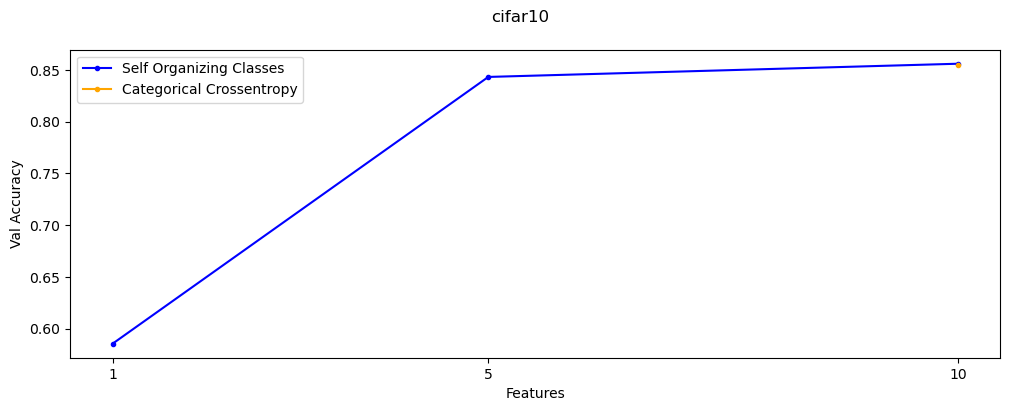

In [15]:
sorted_indices = np.argsort(maxes["self_organizing_classes"]["emb_dims"], axis=0)

cat_cross = (
    maxes["categorical_crossentropy"]["emb_dims"],
    maxes["categorical_crossentropy"]["val_acc"],
)
soc = (
    np.array(maxes["self_organizing_classes"]["emb_dims"])[sorted_indices],
    np.array(maxes["self_organizing_classes"]["val_acc"])[sorted_indices],
)


fig = plt.figure(figsize=(12, 4))
fig.suptitle(DATASET)
ax = fig.add_subplot(111)
ax.plot(*soc, label="Self Organizing Classes", color="blue", marker=".")
ax.plot(*cat_cross, label="Categorical Crossentropy", color="orange", marker=".")
plt.xticks(sorted(set(list(soc[0]) + list(cat_cross[0]))))
plt.xlabel("Features")
plt.ylabel("Val Accuracy")
ax.legend()
plt.show()